<a href="https://colab.research.google.com/github/AnubhavDeepSrivatava/machine-learning/blob/main/imagedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [ ]:
  pip install tensorflow numpy pandas matplotlib opencv-python


In [ ]:
import os
import pandas as pd

In [ ]:
!kaggle datasets download -d rahulm7323/damaged-and-intact-packages
!unzip -q damaged-and-intact-packages.zip -d /content/damaged-and-intact-packages

Dataset URL: https://www.kaggle.com/datasets/rahulm7323/damaged-and-intact-packages
License(s): unknown
damaged-and-intact-packages.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/damaged-and-intact-packages/damaged-and-intact-packages/damaged/damagedfoodpackagingbox0.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
damaged_images_path = "damaged-and-intact-packages/damaged-and-intact-packages/damaged"
intact_images_path = "damaged-and-intact-packages/damaged-and-intact-packages/intact"

In [ ]:

damaged = []
intact = []

for image in os.listdir(damaged_images_path):
    damaged.append((os.path.join(damaged_images_path, image), 1))

for image in os.listdir(intact_images_path):
    intact.append((os.path.join(intact_images_path, image), 0))

In [ ]:
len(damaged), len(intact)

(286, 342)

In [ ]:
damaged_df = pd.DataFrame(damaged, columns = ['img_path', 'class'])
damaged_df['class'] = damaged_df['class'].astype('str')

intact_df = pd.DataFrame(intact, columns = ['img_path', 'class'])
intact_df['class'] = intact_df['class'].astype('str')

In [ ]:
# split the damaged and intact images into train, validation and test images
from sklearn.model_selection import train_test_split

damaged_train_df, damaged_val_df = train_test_split(damaged_df, test_size=0.3, random_state=7)
damaged_val_df, damaged_test_df = train_test_split(damaged_val_df, test_size=0.5, random_state=7)

intact_train_df, intact_val_df = train_test_split(intact_df, test_size=0.3, random_state=7)
intact_val_df, intact_test_df = train_test_split(intact_val_df, test_size=0.5, random_state=7)

In [ ]:
# create the final dataset for train, validation and test that contains both damaged and intact images in equal proportions
train_df = pd.concat([damaged_train_df, intact_train_df])
val_df = pd.concat([damaged_val_df, intact_val_df])
test_df = pd.concat([damaged_test_df, intact_test_df])

# shuffle the dataset
train_df = train_df.sample(frac = 1)
val_df = val_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)

In [ ]:
train_df.head(10)

,img_path,class
53,damaged-and-intact-packages/damaged-and-intact...,1
214,damaged-and-intact-packages/damaged-and-intact...,0
82,damaged-and-intact-packages/damaged-and-intact...,0
1,damaged-and-intact-packages/damaged-and-intact...,0
225,damaged-and-intact-packages/damaged-and-intact...,1
203,damaged-and-intact-packages/damaged-and-intact...,0
25,damaged-and-intact-packages/damaged-and-intact...,1
42,damaged-and-intact-packages/damaged-and-intact...,1
127,damaged-and-intact-packages/damaged-and-intact...,1
287,damaged-and-intact-packages/damaged-and-intact...,0


In [ ]:
import tensorflow as tf

In [ ]:
img_width = 256
img_height = 256
n_channels = 1
batch_size = 16
class_names = ['intact', 'damaged']
num_classes = 2


In [ ]:
# data generator for training dataset, performs data augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)

# data generator for validation and testing dataset, here no data augmentation is performed
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'img_path',
    y_col = 'class',
    target_size = (img_width, img_height),
    color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    seed = 7
)

valid_generator = val_test_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'img_path',
    y_col = 'class',
    target_size = (img_width, img_height),
    color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    seed = 7
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'img_path',
    y_col = 'class',
    target_size = (img_width, img_height),
    color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    seed = 7
)

Found 404 validated image filenames belonging to 2 classes.
Found 88 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 35 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 6 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import os

def create_model_checkpoint(model_name, save_path="model_checkpoints"):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_path, model_name),
    verbose=0,
    save_best_only=True,
    monitor = 'val_accuracy'
  )

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
resnet34_model = ResNet34(shape = (img_width, img_height, 3), classes = 2)


In [ ]:
resnet34_model.summary()

Model: "ResNet34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 131, 131, 64)   │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 131, 131, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 131, 131, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 66, 66, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 66, 66, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 66, 66, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 66, 66, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 66, 66, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 66, 66, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 66, 66, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 66, 66, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 66, 66, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 66, 66, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 66, 66, 64)     │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 27,861,762 (106.28 MB)

 Trainable params: 27,846,530 (106.23 MB)

 Non-trainable params: 15,232 (59.50 KB)

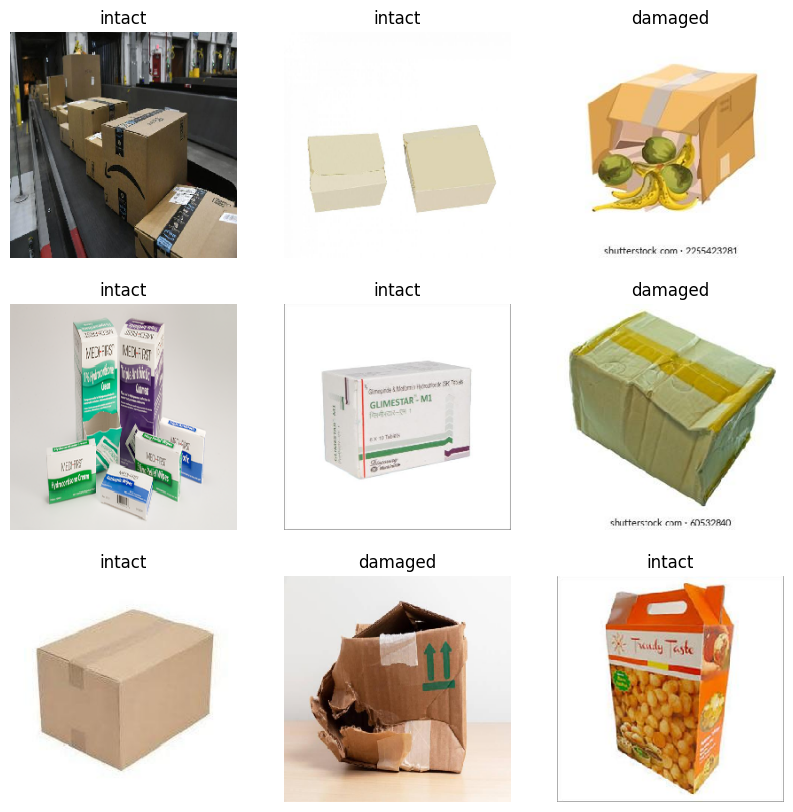

In [ ]:
val_iter = iter(valid_generator)
batch = next(val_iter)

images, labels = batch

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [ ]:
resnet34_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = resnet34_model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 2,
    callbacks = [create_model_checkpoint(model_name='resnet34_model.h5')]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5705 - loss: 14.7017 

26/26 ━━━━━━━━━━━━━━━━━━━━ 477s 17s/step - accuracy: 0.5687 - loss: 14.5576 - val_accuracy: 0.5444 - val_loss: 3078.5730
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 429s 16s/step - accuracy: 0.5253 - loss: 4.4955 - val_accuracy: 0.4000 - val_loss: 92.2594


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

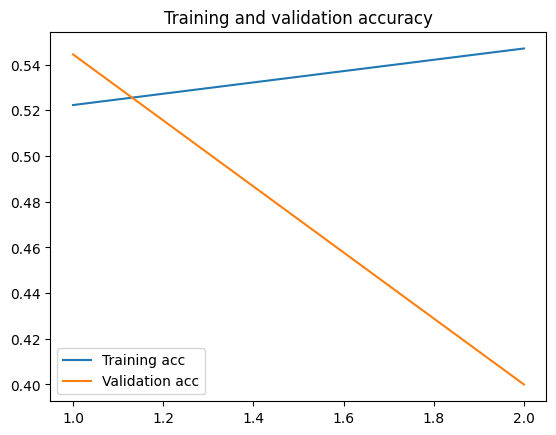

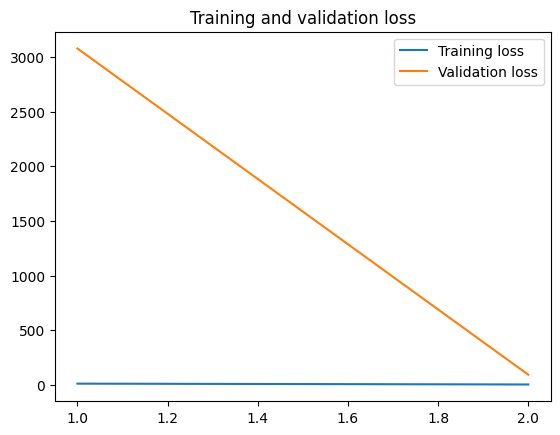

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = resnet34_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.4388 - loss: 84.2214
Test Loss: 92.2593994140625
Test Accuracy: 0.4000000059604645


In [ ]:
# Saving the trained model
resnet34_model.save('resnet34_model.h5')


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('resnet34_model.h5')
class_labels = ["Intact", "Damaged"]

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img = cv2.resize(frame, (224, 224))  # Resize to the model's input size
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    label = class_labels[np.argmax(prediction)]

    # Display the result on the webcam feed
    cv2.putText(frame, label, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Package Damage Detection", frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the trained model
resnet34_model = load_model('resnet34_model.h5')

# Recompile the model after loading
resnet34_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
resnet34_model.save('resnet34_model_with_optimizer.h5')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('resnet34_model_with_optimizer.h5')
class_labels = ["Intact", "Damaged"]

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img = cv2.resize(frame, (224, 224))  # Resize to the model's input size
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    label = class_labels[np.argmax(prediction)]

    # Display the result on the webcam feed
    cv2.putText(frame, label, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Package Damage Detection", frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
